In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.preprocessing import LabelEncoder,label_binarize,StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2,SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import gc
import re
import string
from nltk.stem import PorterStemmer
warnings.filterwarnings("ignore")

In [78]:
def load_and_sample_data(sample_size=20000):
    splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}
    dfs = {}
    for split, file in splits.items():
        df = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + file)
        print(f"Original {split} dataset size: {len(df)}")
        if len(df) > sample_size:
            df = df.sample(n=sample_size, random_state=42)
            print(f"Sampled {split} to {len(df)} rows for faster training")
        dfs[split] = df
    return dfs['train'], dfs['validation'], dfs['test']

In [79]:
train_df, val_df, test_df = load_and_sample_data()

Original train dataset size: 31232
Sampled train to 20000 rows for faster training
Original validation dataset size: 5205
Original test dataset size: 5206


In [80]:
def create_correlation_matrix(df, title):
    # Create numerical features
    df_features = pd.DataFrame()
    df_features['text_length'] = df['text'].apply(len)
    df_features['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df_features['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))
    
    # Encode sentiment labels numerically
    le = LabelEncoder()
    df_features['sentiment_encoded'] = le.fit_transform(df['sentiment'])
    
    # Calculate correlation matrix
    correlation_matrix = df_features.corr()
    
   
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(title)
    plt.show()


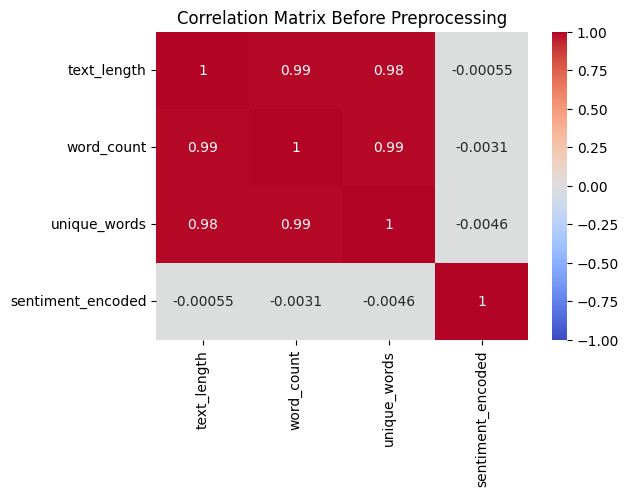

In [81]:

create_correlation_matrix(train_df, "Correlation Matrix Before Preprocessing")

In [57]:
train_df.shape

(20000, 4)

In [58]:
# Display the first few rows of the dataset
print(train_df.head())

          id                                               text  label  \
13132  10477  @mashable I never did thank you for including ...      2   
7794   16099                                Happy Mothers Day!!      2   
28727  18745         Welcome home!  Glad you made it home safe!      2   
23700  26119  @__Jasper_Hale__ *Laughs* that`s because I lik...      2   
19677  25772  Getting ready for work... think I`m catching a...      1   

      sentiment  
13132  positive  
7794   positive  
28727  positive  
23700  positive  
19677   neutral  


In [59]:
train_df.isnull().sum()

id           0
text         0
label        0
sentiment    0
dtype: int64

In [60]:
train_df.duplicated().sum()

np.int64(0)

In [82]:
def text_preprocessing(text):
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Handle contractions better
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'m", " am", text)
    
    # Remove URLs, HTML tags, and email addresses
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Handle repeated characters (e.g., "sooo good" -> "so good")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Remove numbers but keep emoticons
    text = re.sub(r'\d+', '', text)
    
    # # Keep some punctuation that might be important for sentiment
    text = re.sub(r'[^\w\s!?]', ' ', text)
    return text

In [83]:

from collections import Counter

ps = PorterStemmer()

import nltk
nltk.download("stopwords", download_dir="D:/7th SEMESTER/Machine Learning/modelnew/nltk_data")
with open('nltk_data/corpora/stopwords/english', 'r') as file:
    stopwords = set(file.read().splitlines())


[nltk_data] Downloading package stopwords to D:/7th SEMESTER/Machine
[nltk_data]     Learning/modelnew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
# Check class distribution
print("\nClass distribution in training data:")
print(train_df['sentiment'].value_counts())
print(f"\nClass distribution percentages:")
print(train_df['sentiment'].value_counts(normalize=True) * 100)


Class distribution in training data:
sentiment
neutral     7529
positive    6661
negative    5810
Name: count, dtype: int64

Class distribution percentages:
sentiment
neutral     37.645
positive    33.305
negative    29.050
Name: proportion, dtype: float64


In [ ]:
def plot_roc_curves(y_true, y_pred, classes, model_name):
    """Plot ROC curves for multiclass classification"""
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [86]:
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [87]:
x_train = train_df["text"]
y_train = train_df["sentiment"]
x_val = val_df["text"]
y_val = val_df["sentiment"]
x_test = test_df["text"]
y_test = test_df["sentiment"]

print(f"Training set: {x_train.shape}, Test set: {x_test.shape}, Validation set: {x_val.shape}")

Training set: (20000,), Test set: (5206,), Validation set: (5205,)


In [88]:
def create_vectorizer():
    return TfidfVectorizer(
        max_features=8000,        # Increased features
        min_df=10,                  # Reduced min_df for more features
        max_df=0.7,               # Slightly increased max_df
        stop_words='english',
        ngram_range=(1, 2),        # Include trigrams
        sublinear_tf=True,         # Apply sublinear tf scaling
        norm='l2',
        use_idf=True,
        smooth_idf=True,
        lowercase=True,
        token_pattern=r'[a-zA-Z]{3,}',
        binary=False,              
        strip_accents='unicode'
    )

tfidf_vec = create_vectorizer()

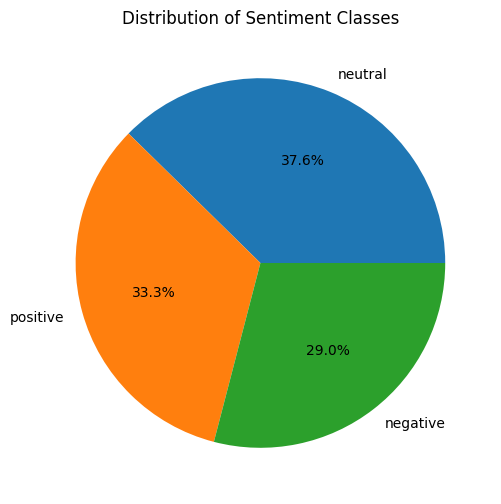

In [89]:
counts = y_train.value_counts()
plt.figure(figsize=(8, 6))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribution of Sentiment Classes')
plt.show()

In [90]:

def detailed_scores(y_true, y_pred, dataset_name="Dataset"):
    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    print(f'\n{dataset_name} Scores:')
    print(f'  Accuracy: {acc:.4f}')
    print(f'  Weighted F1: {f1_weighted:.4f}')
    print(f'  Macro F1: {f1_macro:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    
    return acc, f1_weighted, f1_macro

In [91]:
def create_feature_pipeline():
    """Create a pipeline for feature processing with dimensionality reduction"""
    return Pipeline([
        ('feature_selection', SelectPercentile(chi2, percentile=80)),  # Keep top 80% of features
        ('svd', TruncatedSVD(n_components=2000, random_state=42)),     # Dimensionality reduction
        ('scaler', StandardScaler())                                   # Standardize features
    ])
    

In [92]:
def train_multiple_models(x_train, x_val, x_test, y_train, y_val, y_test):


    print("Applying text preprocessing...")
    x_train_processed = [text_preprocessing(text) for text in x_train]
    x_val_processed = [text_preprocessing(text) for text in x_val]
    x_test_processed = [text_preprocessing(text) for text in x_test]

    # Vectorize processed text
    tfidf_vec = create_vectorizer()
    x_train_vectorized = tfidf_vec.fit_transform(x_train_processed)
    x_val_vectorized = tfidf_vec.transform(x_val_processed)
    x_test_vectorized = tfidf_vec.transform(x_test_processed)


    # Initialize and fit LabelEncoder
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)


    print("Applying  feature selection...")
    feature_pipeline = create_feature_pipeline()
    x_train_processed_features = feature_pipeline.fit_transform(x_train_vectorized, y_train_encoded)
    x_val_processed_features = feature_pipeline.transform(x_val_vectorized)
    x_test_processed_features = feature_pipeline.transform(x_test_vectorized)

    # Use stratified k-fold for better validation
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    models = {
        'Regularized Logistic Regression': {
            'model': LogisticRegression(
                random_state=42, 
                max_iter=1000,
                class_weight='balanced',
                #solver='liblinear',
                fit_intercept=True,
                multi_class='multinomial'
            ),
            'params': {
                'C': [0.0001, 0.001, 0.01],  # Stronger regularization
                'penalty': [ 'l2'],   # Try both L1 and L2
            }
        },
        'Regularized Linear SVM': {
            'model': LinearSVC(
                random_state=42, 
                max_iter=2000,
                class_weight='balanced',
                dual=False,
            ),
            'params': {
                'C': [0.0001, 0.001, 0.01],  # Stronger regularization
                'penalty': ['l2'],
                'loss': ['hinge', 'squared_hinge']
            }
        },
        'Regularized Random Forest': {
            'model': RandomForestClassifier(
                random_state=42, 
                class_weight='balanced',
                n_jobs=-1,
                bootstrap=True,
                oob_score=True,    
            ),
            'params': {
                'n_estimators': [ 100],
                'max_depth': [ 5],      # Reduced depth
                'min_samples_split': [50], # Increased
                'min_samples_leaf': [ 25],  # Increased
                'max_features': ['sqrt', 'log2'],  # More restrictive
                'max_samples': [0.6],
                'min_impurity_decrease': [0.001]      # Bootstrap sampling ratio
            }
        }
    }
    
    results = {}
    classes = label_encoder.classes_
    
    
    for name, config in models.items():
        print(f"\n{'='*60}")
        print(f"Training {name}...")

        gc.collect()
        
        
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=cv_strategy,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1,
            return_train_score=True
        )
        
        
        # # Fit the model
        grid_search.fit(x_train_processed_features, y_train_encoded)
        
        # Get best model
        best_model = grid_search.best_estimator_
        
        # Make predictions
        y_train_pred = best_model.predict(x_train_processed_features)
        y_val_pred = best_model.predict(x_val_processed_features)
        y_test_pred = best_model.predict(x_test_processed_features)
        
        y_train_pred_decoded = label_encoder.inverse_transform(y_train_pred)
        y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
        
        # Calculate scores
        train_acc, train_f1_w, train_f1_m = detailed_scores(y_train, y_train_pred_decoded, "Training")
        test_acc, test_f1_w, test_f1_m = detailed_scores(y_test, y_test_pred_decoded, "Test")
        
        # Check for overfitting
        overfitting_score = train_acc - test_acc
        print(f"\nOverfitting Score (Train - Test): {overfitting_score:.4f}")
        if overfitting_score > 0.05:
            print(" WARNING: Model shows signs of overfitting!")
        
        # Store results
        results[name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_f1_weighted': train_f1_w,
            'test_f1_weighted': test_f1_w,
            'overfitting_score': overfitting_score,
            'y_test_pred': y_test_pred_decoded
        }
        
        print(f"\nBest Parameters: {grid_search.best_params_}")
        print(f"Cross-validation Score: {grid_search.best_score_:.4f}")
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_test_pred_decoded, classes, name)
        plot_roc_curves(y_test, y_test_pred_decoded, classes,name)
        
       
    
    return results, label_encoder, tfidf_vec, feature_pipeline

Applying text preprocessing...
Applying  feature selection...

Training Regularized Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Training Scores:
  Accuracy: 0.7320
  Weighted F1: 0.7324
  Macro F1: 0.7335
  Precision: 0.7329
  Recall: 0.7320

Test Scores:
  Accuracy: 0.6418
  Weighted F1: 0.6423
  Macro F1: 0.6435
  Precision: 0.6432
  Recall: 0.6418

Overfitting Score (Train - Test): 0.0902

Best Parameters: {'C': 0.0001, 'penalty': 'l2'}
Cross-validation Score: 0.6432


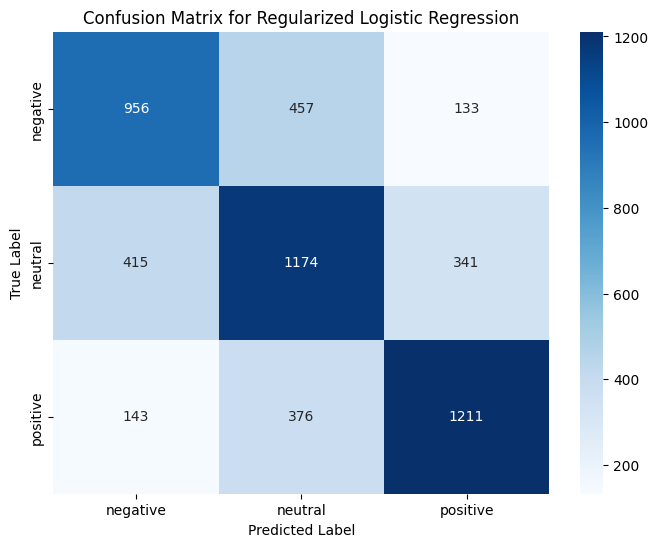

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [93]:
results, label_encoder, tfidf_vec, create_feature_pipeline = train_multiple_models(
        x_train, x_val, x_test, y_train, y_val, y_test
    )

In [25]:
print(type(results))

<class 'dict'>


In [26]:
best_model = max(results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\nBest performing model: {best_model[0]} with {best_model[1]['test_accuracy']:.3f} accuracy")






Best performing model: Regularized Linear SVM with 0.644 accuracy


In [27]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Fit with training labels
print(label_encoder.classes_)

['negative' 'neutral' 'positive']


In [28]:
def predict_sentiment(text, vectorizer, model, label_encoder):
    processed_text = text_preprocessing(text)
    vectorized_text = vectorizer.transform([processed_text])
    processed_features = create_feature_pipeline.transform(vectorized_text)
    prediction_encoded = model.predict(processed_features)[0]  
    prediction_decoded = label_encoder.inverse_transform([prediction_encoded])[0]  
    return prediction_decoded


best_model = max(results.items(), key=lambda x: x[1]['test_accuracy'])  # Select best model
best_model_name = best_model[0]  
best_model_obj = results[best_model_name]['model']  # Access model from dictionary
example_text = "great product"  # Example text for prediction
prediction = predict_sentiment(example_text, tfidf_vec, best_model_obj, label_encoder)
print(f"\nExample prediction: '{example_text}' -> {prediction}")


Example prediction: 'great product' -> positive


In [29]:
import joblib


def save_best_model(vectorizer, best_model_name, results):
    if vectorizer is not None:
        joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
        print("Vectorizer saved!")

    # if feature_pipeline is not None:
    #     joblib.dump(feature_pipeline, 'feature_pipeline.pkl')
    #     print("Feature pipeline saved!")
    
    best_result = results[best_model_name]
    filename = f'best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(best_result['model'], filename)
    print(f"Best model '{best_model_name}' saved as {filename}")


# Save only the best model
save_best_model(tfidf_vec, best_model[0], results)

Vectorizer saved!
Best model 'Regularized Linear SVM' saved as best_model_regularized_linear_svm.pkl
